In [43]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
mpl.rcParams['font.sans-serif'] = ['Times New Roman']
mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import cv2 
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [44]:
with open('./speed_per_20.npz', 'rb') as f:
    arr = np.load(f)

In [45]:
arr.shape 

(8, 540, 960, 2)

In [46]:
total_frame = arr.shape[0]

In [47]:
h, w = arr.shape[1:3]
fx, fy = arr[:, :,:,0], arr[:, :,:,1]

ang = np.arctan2(fy, fx) + np.pi
v = np.sqrt(fx*fx+fy*fy)

In [48]:
hsv = np.zeros((ang.shape[0], h, w, 3), np.uint8)

In [49]:
hsv[...,0] = ang*(180/np.pi/2)
hsv[...,1] = 255
hsv[...,2] = np.minimum(v*4, 255)

In [50]:
bgr = np.array([cv2.cvtColor(hsv[i], cv2.COLOR_HSV2RGB).tolist() for i in range(8)])

计算速度和绘制流体边界

In [51]:
vx = arr[:, :, :, 1]
vy = arr[:, :, :, 0]
v = np.sqrt(vx * vx + vy * vy)

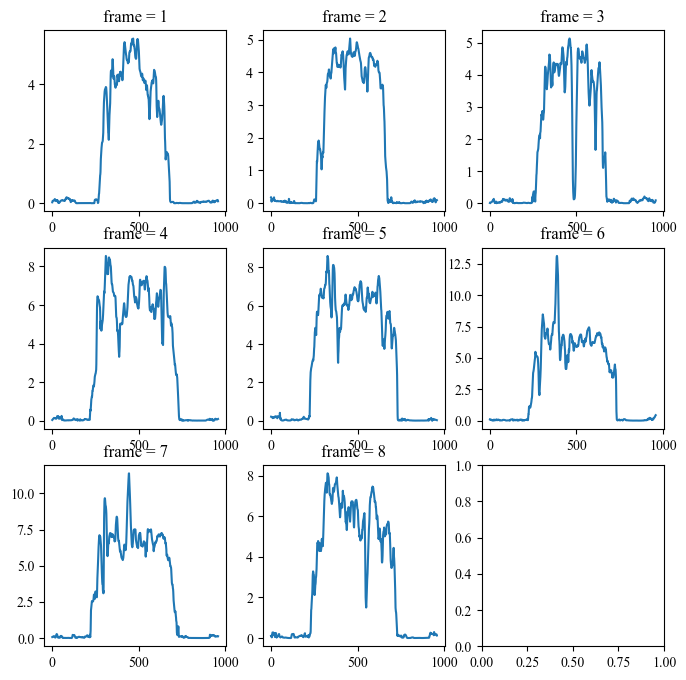

In [52]:
def plot_frame_with_y(y = 0):
    fig, axes = plt.subplots(3, 3)
    fig.set_size_inches(8, 8)
    for i in range(total_frame):
        ax = axes.flatten()[i]
        ax.set_title(f"frame = {i + 1}")
        ax.plot(v[i, y, :])
plot_frame_with_y()

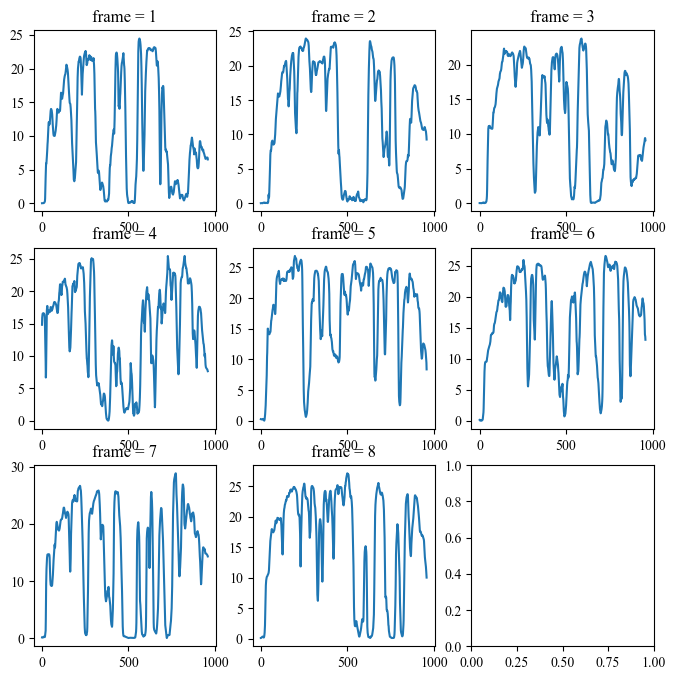

In [31]:
plot_frame_with_y(y = 450)

In [32]:
def calc_flow_index(frame_index = 0, y_ind = 120):
    different_map = np.where(bgr[frame_index].sum(axis = 2) == 0, 0, 255 )
    start_index = different_map[y_ind, :].tolist().index(255)
    end_index = 960 - different_map[y_ind, :].tolist()[::-1].index(255) - 1
    indices = np.array([*range(0, 421, 60)])
    map_indices = (indices * (end_index - start_index) / 420).astype("int")
    return map_indices

In [33]:
calc_flow_index(frame_index=1)

array([  0,  78, 157, 236, 315, 394, 473, 552])

真实值

In [34]:
real_point = np.array("1.013	2.867	4.263	4.442	4.229	3.516	3.814	2.278".split("\t"), dtype="float")

In [35]:
dic = {
    "frame" : [], 
    "y_ind" : [], 
    "pearsonr" : []
}
for frame in range(total_frame):
    for y_ind in range(0, 540, 10):
        # print(y_ind)
        map_indices = calc_flow_index(frame_index=frame, y_ind=y_ind)
        pred = v[frame][y_ind, map_indices]
        lr = LinearRegression(fit_intercept=True)

        corr, p = pearsonr(real_point, pred)
        dic["frame"].append(frame)
        dic["y_ind"].append(y_ind)
        dic["pearsonr"].append(corr)
    print(frame)

0
1
2
3
4
5
6
7


In [36]:
resut = pd.DataFrame(dic)

In [37]:
resut = resut.sort_values(by = "pearsonr", ascending=False)

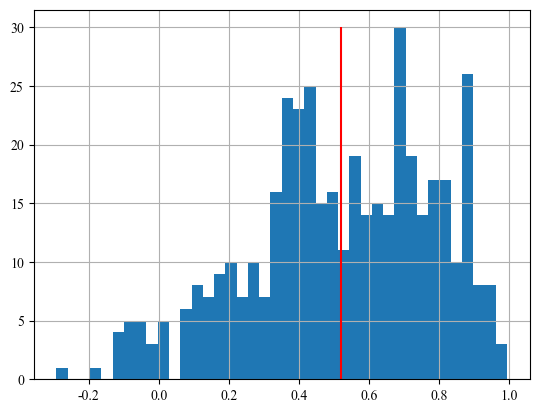

In [42]:
resut["pearsonr"].hist(bins = 40)
plt.vlines(x = resut["pearsonr"].mean(), ymin=0, ymax=30, color = "red")

<Axes: >

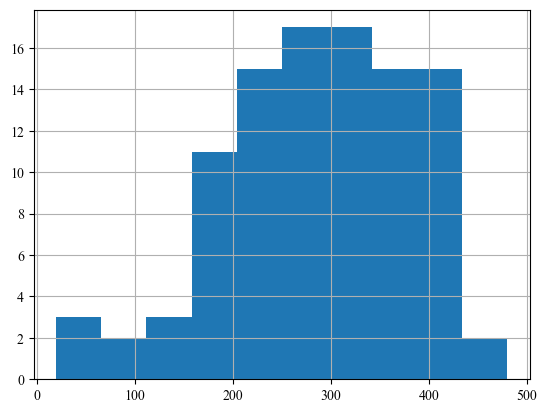

In [20]:
resut.head(100)["y_ind"].hist()

In [31]:
# frame, y_ind = resut.iloc[0, :][["frame", "y_ind"]].values.astype("int").tolist()
# frame, y_ind = 

In [32]:
indicies = calc_flow_index(frame_index=frame, y_ind=y_ind)

In [33]:
pred = v[frame][y_ind, indicies]

In [34]:
lr = LinearRegression(fit_intercept=True)
lr.fit(pred.reshape(-1, 1), real_point)

LinearRegression()

In [35]:
# lr.intercept_b
pred

array([9.09802273e-03, 1.21704769e+01, 1.93217066e+01, 1.97518557e+01,
       1.89692093e+01, 1.50876900e+01, 1.63100992e+01, 9.35509280e+00])

In [36]:
lr.coef_

array([0.17649953])

In [37]:
validate_speed = pred * lr.coef_ + lr.intercept_
validate_speed

array([0.85597128, 3.00244899, 4.26463769, 4.3405588 , 4.20242209,
       3.51733575, 3.73309039, 2.50553501])

In [38]:
real_point

array([1.013, 2.867, 4.263, 4.442, 4.229, 3.516, 3.814, 2.278])

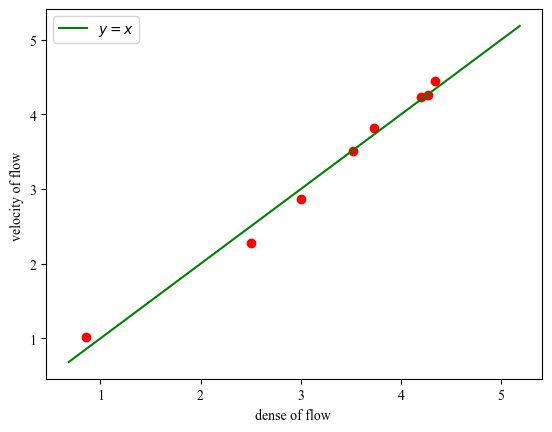

In [39]:
step = np.arange(validate_speed.min() * 0.8 , validate_speed.max() * 1.2, 0.1)
plt.scatter(validate_speed, real_point, color = "red")
plt.plot(step, step , label = "$y = x$", color = "green")
plt.xlabel("dense of flow ")
plt.ylabel("velocity of flow ")
plt.legend()

In [41]:
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
r2_score(validate_speed, real_point)

0.9884859308663072